<a href="https://colab.research.google.com/github/liachicue/Linear_Regression_Models/blob/main/RegresionCOVID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COVID Regresión Lineal: Máxima Verosimilitud y Regresión Bayesiana

**Machine Learning**

**Universidad Tecnológica de Pereira**

*Maestría en Ingeniería de Sistemas y Computación*

*Prof. Hernán Felipe García Arias, PhD*

*2021-2*

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import  interact, widgets
from sklearn.metrics import  r2_score,mean_squared_error
from sklearn.linear_model import BayesianRidge

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving owid-covid-data.csv to owid-covid-data.csv


# Regresión Lineal: Máxima Verosimilitud

El presente modelo se define a partir de una combinación lineal de funciones no lineales fijas de las variables de entrada, 
\begin{align}
y({\bf{x}},{\bf{w}}) = w_0 + \sum_{i=1}^{M-1}\ w_i\phi_i({\bf{x}}) = {\bf{w}}^T\phi({\bf{x}})
\end{align}

Donde:
- ${\bf{w}} = [w_0,w_1,\cdots,w_{M-1}]^{\top}\in \mathbb{R}^{M\times 1} $ : nuestro modelo, w es un vector columna de numeros reales
- ${\bf{\phi({\bf{x}})}} = [\phi_0({\bf{x}}),\phi_1({\bf{x}}),\cdots,\phi_{M-1}({\bf{x}})]^{\top}\in \mathbb{R}^{M\times 1} $ : nuestra proyección de la observación $\bf{x}$ a través de las funciones base 

A continuación, se utilizaran las siguientes funciones base $\phi_i(x)$:

- Polinomial: $\phi_i(x) = x^i$
- Exponencial: $\phi_i(x) = e^{-\frac{(x-\mu_i)^2}{2s^2}}$
- Sigmoidal: $\phi_i(x) = \sigma{\frac{x-\mu_i}{s}} , \sigma(a) = \frac{1}{1+ e^{-a}}$ 

La solución de máxima verosimilitud para ${\bf{w}}$ está dada como:
\begin{align}
{\bf{w}}_{ML} = (\phi^T \phi)^{-1}\phi^T{\bf{t}}
\end{align}

Recordemos que para realizar una predicción:
\begin{align}
y({\bf{x}}_n,{\bf{w}}) = {\bf{w}}_{ML}^{\top}{\bf{\phi(x_n)}}
\end{align}

Cargamos nuestra Base de Datos

In [ ]:
dataSet = pd.read_csv('owid-covid-data.csv')


Como prueba tenemos Colombia, China e Italia

In [ ]:
### Para Colombia
posCOVID_COL = dataSet['location'].str.contains('Colombia')
dataCOVID_COL = dataSet[posCOVID_COL]
dataCOVID_COL[:5]

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality
22980,COL,South America,Colombia,2020-03-06,1.0,1.0,NaN,NaN,NaN,NaN,0.020,0.020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.04,51265841.0,44.223,32.2,7.646,4.312,13254.949,4.5,124.24,7.44,4.7,13.5,65.386,1.71,77.29,0.767,NaN,NaN,NaN
22981,COL,South America,Colombia,2020-03-07,1.0,0.0,NaN,NaN,NaN,NaN,0.020,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.04,51265841.0,44.223,32.2,7.646,4.312,13254.949,4.5,124.24,7.44,4.7,13.5,65.386,1.71,77.29,0.767,NaN,NaN,NaN
22982,COL,South America,Colombia,2020-03-08,1.0,0.0,NaN,NaN,NaN,NaN,0.020,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.04,51265841.0,44.223,32.2,7.646,4.312,13254.949,4.5,124.24,7.44,4.7,13.5,65.386,1.71,77.29,0.767,-319.6,-0.67,-2.95
22983,COL,South America,Colombia,2020-03-09,1.0,0.0,NaN,NaN,NaN,NaN,0.020,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.81,51265841.0,44.223,32.2,7.646,4.312,13254.949,4.5,124.24,7.44,4.7,13.5,65.386,1.71,77.29,0.767,NaN,NaN,NaN
22984,COL,South America,Colombia,2020-03-10,3.0,2.0,NaN,NaN,NaN,NaN,0.059,0.039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.81,51265841.0,44.223,32.2,7.646,4.312,13254.949,4.5,124.24,7.44,4.7,13.5,65.386,1.71,77.29,0.767,NaN,NaN,NaN


In [ ]:
### Para China
posCOVID_Chn = dataSet['location'].str.contains('China')
dataCOVID_Chn = dataSet[posCOVID_Chn]
dataCOVID_Chn[:5]

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality
22369,CHN,Asia,China,2020-01-22,548.0,NaN,NaN,17.0,NaN,NaN,0.379,NaN,NaN,0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.39,1.444216e+09,147.674,38.7,10.641,5.929,15308.712,0.7,261.899,9.74,1.9,48.4,NaN,4.34,76.91,0.761,NaN,NaN,NaN
22370,CHN,Asia,China,2020-01-23,641.0,93.0,NaN,18.0,1.0,NaN,0.444,0.064,NaN,0.012,0.001,NaN,3.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.91,1.444216e+09,147.674,38.7,10.641,5.929,15308.712,0.7,261.899,9.74,1.9,48.4,NaN,4.34,76.91,0.761,NaN,NaN,NaN
22371,CHN,Asia,China,2020-01-24,918.0,277.0,NaN,26.0,8.0,NaN,0.636,0.192,NaN,0.018,0.006,NaN,3.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.91,1.444216e+09,147.674,38.7,10.641,5.929,15308.712,0.7,261.899,9.74,1.9,48.4,NaN,4.34,76.91,0.761,NaN,NaN,NaN
22372,CHN,Asia,China,2020-01-25,1401.0,483.0,NaN,42.0,16.0,NaN,0.970,0.334,NaN,0.029,0.011,NaN,3.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.69,1.444216e+09,147.674,38.7,10.641,5.929,15308.712,0.7,261.899,9.74,1.9,48.4,NaN,4.34,76.91,0.761,NaN,NaN,NaN
22373,CHN,Asia,China,2020-01-26,2067.0,666.0,NaN,56.0,14.0,NaN,1.431,0.461,NaN,0.039,0.010,NaN,3.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.91,1.444216e+09,147.674,38.7,10.641,5.929,15308.712,0.7,261.899,9.74,1.9,48.4,NaN,4.34,76.91,0.761,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22975,CHN,Asia,China,2021-09-19,95801.0,49.0,70.000,4636.0,0.0,0.0,66.334,0.034,0.048,3.210,0.000,0.0,1.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.177638e+09,NaN,NaN,NaN,3595000.0,4216857.0,150.78,NaN,NaN,NaN,2920.0,NaN,1.444216e+09,147.674,38.7,10.641,5.929,15308.712,0.7,261.899,9.74,1.9,48.4,NaN,4.34,76.91,0.761,NaN,NaN,NaN
22976,CHN,Asia,China,2021-09-20,95873.0,72.0,67.143,4636.0,0.0,0.0,66.384,0.050,0.046,3.210,0.000,0.0,1.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.180986e+09,NaN,NaN,NaN,3348000.0,4066571.0,151.02,NaN,NaN,NaN,2816.0,NaN,1.444216e+09,147.674,38.7,10.641,5.929,15308.712,0.7,261.899,9.74,1.9,48.4,NaN,4.34,76.91,0.761,NaN,NaN,NaN
22977,CHN,Asia,China,2021-09-21,95914.0,41.0,62.571,4636.0,0.0,0.0,66.412,0.028,0.043,3.210,0.000,0.0,1.14,NaN,NaN,NaN,N

In [ ]:
### Para Italia
posCOVID_IT = dataSet['location'].str.contains('Italy')
dataCOVID_IT = dataSet[posCOVID_IT]
dataCOVID_IT[:5]

Almacenamos nuestos valores de prueba y observacion

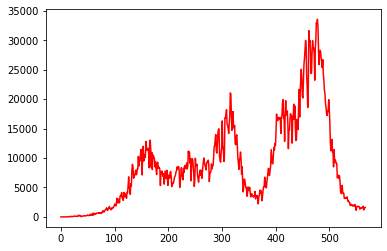

In [ ]:
newCases_COL = dataCOVID_COL['new_cases'].fillna(0)
#newCases_Chn = dataCOVID_Chn['new_cases'].fillna(0)
#newCases_IT = dataCOVID_IT['new_cases'].fillna(0) #
x = np.linspace(0.,len(newCases_COL),len(newCases_COL)) 
# Normalizamos entr 0-1 las observaciones (dias)
x_train = x/x.max()
y_train = newCases_COL.values

invBeta = 0.1
t_ideal = y_train
t = t_ideal + invBeta*np.random.rand(len(x))

plt.plot(x,y_train,'-r')
plt.show()


Definimos las funciones Base

In [ ]:
def polyFbase(xn, M, var):
  var=0;
  idx = np.linspace(0,M-1,M)
  phi_xn = np.power(xn,idx)
  
  return phi_xn

In [ ]:
def expFbase(xn,M,var):
  miu =  np.linspace(0,1,M)
  phi_expn =np.zeros(M)
  #var = 0.01

  for i in range(0,M):
    phi_expn[i] = np.exp(-1*((xn-miu[i])**2)/(2*var)) 
  
  return phi_expn

In [ ]:
def sigmFbase(xn,M,var):
  miu =  np.linspace(0,1,M)
  phi_sig =np.zeros(M)
  #var = 0.1 
  
  for i in range (0,M):
    phi_sig[i] = 1/(1 + np.exp(-(xn - miu[i])/var ) )
  
  return phi_sig

Definimos la matriz de diseño 

In [ ]:
def MatrizDesign(X,tipoFBase,M,var):
  N = len(X)
  mPHI = np.zeros((N,M))
  for n in range (0,N): #xobs in X 
    if tipoFBase == 'poly':
      phi_xn = polyFbase(X[n],M,var)
    elif tipoFBase == 'exp':
        phi_xn = expFbase(X[n],M,var)
    elif tipoFBase == 'sigmoidal':
        phi_xn = sigmFbase(X[n],M,var)
    mPHI[n,:]=phi_xn
  return mPHI

## Version Compacta Interactiva

In [ ]:
@interact(var = widgets.FloatSlider(min=1e-4, max=1, step=0.001, value=0.01,readout_format='.4f'),numFbase = (1,1000,3),reg_param = widgets.FloatSlider(min=1e-4, max=1, step=0.001, value=0.1,readout_format='.4f'), regFlag =[True,False], typeFBase = ['poly', 'exp', 'sigmoidal'])
def ExperimentoRegresionLineal(numFbase,var,typeFBase,regFlag,reg_param):
  x = np.linspace(0.,len(newCases_COL),len(newCases_COL)) 
  invBeta = 0.1
  t_ideal = y_train
  t = t_ideal + invBeta*np.random.rand(len(x))

  Mx_X = x.max()
  Mx_t = t.max()

  x = x/Mx_X
  t = t/Mx_t

  # Podemos calcular nuestro w_ML
  MPHI = MatrizDesign(x,typeFBase,numFbase,var)
  MPHIT = MPHI.T
  
  if regFlag == False:
    #w_ML = np.linalg.inv(MPHIT@MPHI)@(MPHIT@t)
    w_ML = np.linalg.inv(MPHIT@MPHI)@(MPHIT@t)
  else:
    w_ML = np.linalg.inv(MPHIT@MPHI + np.eye(numFbase)*reg_param )@(MPHIT@t) # Conregularización spoiler
  # Se pueden estimar todas las etiquetas a la vez porque MPHI (N*M) y w_ML (M*1)
  yEst = MPHI@w_ML

  errorMSE = 0.5*((t-yEst).T)@(t-yEst)
  errorR2 = r2_score(t,yEst)

  print("MSE: ",errorMSE)
  print("R2: ",errorR2)
  
  plt.plot(x*Mx_X, t_ideal, '-r')
  #plt.plot(x*Mx_X,t_ideal, 'ob')
  plt.plot(x*Mx_X,yEst*Mx_t, '-g')


  plt.xlabel(r'$x_n$')
  plt.ylabel(r'$t_n$')
  plt.legend(('t_ideal','Etq Est'))
  plt.show()
  


  #print("w_ML: ",w_ML)

interactive(children=(IntSlider(value=499, description='numFbase', max=1000, min=1, step=3), FloatSlider(value…


Observemos el comportamiento de la predicción sin activar el parámetro de regularización. 

A pesar de tener la cantidad de parámetros del modelo muy pequeño, $numFBase =100$ , vemos que la predicción del sistema se encuentra con sobre entrenamiento. Esto se debe a que el coeficiente de regularización reduce la magnitud de los coeficientes $w$. 

Al activar dicho parámetro $reg_{param}=0.1$ la complejidad del modelo es controlada y propende a que la función de error siga siendo una función cuadrática de $w$. Es por esto ultimo, que en la máxima verosimilitud, el minimo error exacto se puede encontrar derivando la suma de los cuadrados de los errores entre las predicciones y los valores "originales". 

Es evidente, entonces, que la regularización permite limitar y manipular modelos complejos con conjuntos de datos de gran tamaño. 

En los ejemplos analizados acontinuación se utilizará un coeficiente de regulación igual a $reg_{param}=0.1$. 

Ahora bien, la regresión de máxima verosimilitud se realiza a partir de funciones de base. Esto da cabida a la pregunta; ¿Qué tipo de función base tiene la mejor respuesta? Cada función base tiene tanto su utilidad como problema idk.

Por ejemplo, miremos la respuesta de la funcion base exponencial con $numFBase = 100$ y $varianza = 0.01$. La respuesta que obtenemos es una secuencia de funciones gaussianas. Esto resulta de una suceción de funciones polinómicas ajustables a una region especifica del espacio. 

Sí en ejemplo anterior cambiamos nuestra función de base a una sigmoidal, la predicción será una función entre 0 y 1. Esto es muy bueno debido a que las observaciones (dias) estan normalizadosentre 0 y 1. 

# Regresión Bayesiana

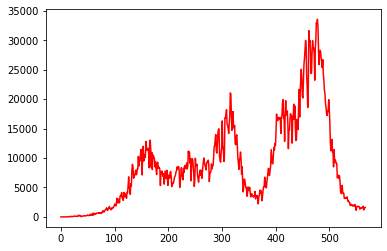

In [ ]:
# Modelo COVID Bayesiano

newCasesHistorico = dataCOVID_COL['new_cases'].fillna(0)
x = np.linspace(0.,len(newCasesHistorico),len(newCasesHistorico)) 
x_train = x/x.max()
y_train = newCasesHistorico.values

x_test = x_train
y_test = y_train
#x_test = x[:280]
#y_train = y[:800]

#x_test = x[280:]
#y_test = y[800:] 


t = y_train + 0.1*np.random.rand(len(x))

plt.plot(x,y_train,'-r')
plt.show()


## Version Compacta Interactiva

In [ ]:
@interact(var  = widgets.FloatSlider(min=1e-4, max=1, step=0.001, value=0.01,readout_format='.4f'), typeFBase = ['poly', 'exp', 'sigmoidal'], CantBase = (1,1000,3), Alfa_Param = (1,100,3), Lambda_Param = widgets.FloatSlider(min=1e-4, max=1, step=0.001, value=0.1,readout_format='.4f'))
def Experimeto1(CantBase,typeFBase,var,Alfa_Param,Lambda_Param):
  # Matriz de Vandermode para emular la función base Polinomial de orden M
  PHI_train = MatrizDesign(x_train,typeFBase,CantBase+1,var)
  PHI_test = MatrizDesign(x_test,typeFBase,CantBase+1,var)
  
  # Instanciemos nuestros modelo Bayesiano
  modelReg = BayesianRidge(tol = 1e-6, fit_intercept=False, compute_score=True, alpha_init=Alfa_Param,lambda_init=Lambda_Param)
  
  # Creemos entonces nuestros parámetros iniciales del problema alpha y lambda
  init = [Alfa_Param,Lambda_Param] # alpha = 1, lambda = 0.0001
  modelReg.fit(PHI_train,y_train)
  
  ymean_test, ystd_test = modelReg.predict(PHI_test, return_std=True)  # Realizamos la predicción
  
  c = modelReg.coef_ 

  plt.plot(x_train,y_train,'-b',alpha = 0.5)
  #plt.plot(x_test,y_test,'-y')
  plt.plot(x_train,ymean_test,'-r')
  plt.fill_between(x_test,ymean_test-ystd_test,ymean_test+ystd_test,color='pink',alpha=0.5)
  plt.legend(('Observaciones',r"Etq GroundTruth: $sin(2\pi x)$",'Media predictiva','Std predictiva'))
  
  #plt.ylim(-1.5,1.5)
  
  titulo = "$\\alpha$_init$ = {:.2f},\\ \\lambda$_ini$={}$".format(init[0],init[1])
  
  stringResultado = "$\\alpha = {:.2f}$\n $\\lambda={:.3f}$\n $L = {:.1f}$".format(modelReg.alpha_init,modelReg.lambda_init, modelReg.scores_[-1])
  
  plt.text(0.05,-1.0,stringResultado)
  plt.title(titulo)
  plt.show()

  errorMSE1 = 0.5*((t-ymean_test).T)@(t-ymean_test)
  errorR21 = r2_score(t,x_train)

  print("MSE: ",errorMSE1)
  print("$L$ ",modelReg.scores_[-1])
  print("R2.1: ",errorR21)


interactive(children=(IntSlider(value=499, description='CantBase', max=1000, min=1, step=3), Dropdown(descript…

Con el fin de visualizar el comportamiento de esta predicción, porponemos los siguientes tres ejemplos con los siguientes valores constantes $CantBase = 500$, $varianza=0.01$. Evaluaremos el comportamiento para diferentes valores iniciales de $\alpha$ (precisión), y $\lambda$ (regularización). 

L representa el valor de la probabilidad marginal logarítmica (que se maximizará) en cada iteración de la optimización, lo que nosotros conocemos como posterior. 

Para Funcion Base Polinomial:
\begin{array}{|c|c|}
 \hline
  \alpha&\lambda &  L \\ \hline
      1 &   0   & -5,38 x10^{15} \\ \hline
     50 & 0.5  &  -5,38 x10^{14} \\ \hline
   100  & 1    & -5,38 x10^{14} \\ \hline
\end{array}

Para Funcion Base Exponencial:
\begin{array}{|c|c|}
 \hline
  \alpha&\lambda &  L \\ \hline
      1 &   0   & -5,38 x10^{16} \\ \hline
     50 & 0.5  &  -5,15 x10^{16} \\ \hline
   100  & 1    & -5,15 x10^{16} \\ \hline
\end{array}

Para Funcion Base Sigmoidal:
\begin{array}{|c|c|}
 \hline
  \alpha&\lambda &  L \\ \hline
      1 &   0   & -5,08 x10^{16} \\ \hline
     50 & 0.5  &  -5,08 x10^{16} \\ \hline
   100  & 1    & -5,08 x10^{16} \\ \hline
\end{array}

Como se puede observar en las tablas, el valor del posterior no varia a grandes rasgos entre los valores para $\alpha$ y $\lambda$. Sin embargo, dependiendo del tipo de funcion base, el valor para el posterior cambiará. Esto se debe al tipo de señal que genera cada funcion.